# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [2]:
import pickle
import numpy as np

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = y_train.shape[0]

n_validation = y_valid.shape[0]

n_test = y_test.shape[0]

image_shape = X_train.shape[1:3]

n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Sample Sign Class ID:  4


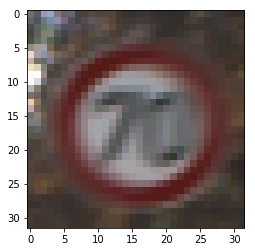

In [4]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

random_index = random.randint(0, len(X_train))
image = X_train[random_index].squeeze()
plt.imshow(image)
print("Sample Sign Class ID: ", y_train[random_index])

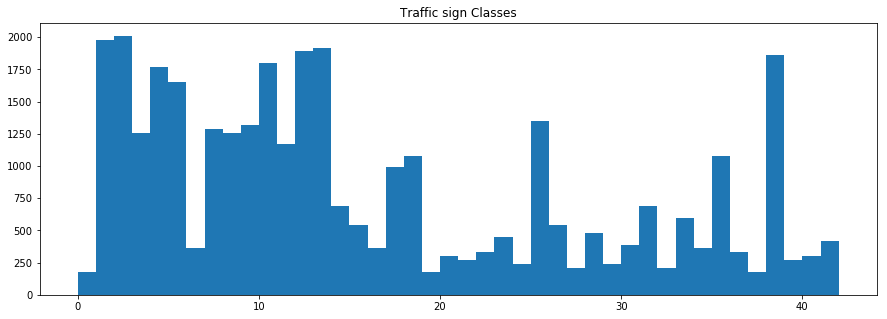

In [5]:
plt.figure(figsize=(15,5))
plt.hist(y_train, bins=range(n_classes))
plt.title("Traffic sign Classes")
plt.subplot(1,1,1)


### Pre-process the Data Set (normalization, grayscale, etc.)

4


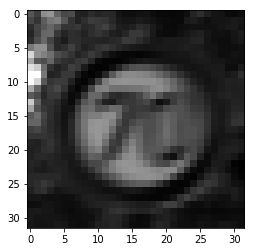

In [6]:
import cv2

# Grayscale image
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

def normalize(features):
    normalized_features = []
    for feature in features:
        normalized_features.append(normalize_grayscale(grayscale(feature)).reshape((32,32,1)))
    return normalized_features

X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

gray = X_train[random_index]
plt.imshow(gray.squeeze(), cmap="gray")
print(y_train[random_index])

### Model Architecture

In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [8]:
import tensorflow as tf

EPOCHS = 25
BATCH_SIZE = 128

In [9]:
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout_rate):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x24.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x24. Output = 14x14x24.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input 14x14x24 Output = 10x10x48.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 48), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(48))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x48. Output = 5x5x48.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x48. Output = 1200.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1200. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1200, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Prevent Overfitting.
    fc1 = tf.nn.dropout(fc1, dropout_rate[0])

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Prevent Overfitting
    fc2 = tf.nn.dropout(fc2, dropout_rate[0])

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.nn.bias_add(tf.matmul(fc2, fc3_W), fc3_b, name='logits_name')
    
    return logits

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x_name')
y = tf.placeholder(tf.int32, (None), name='y_name')
dropout_rate = tf.placeholder(tf.float32, (1), name='dropout_rate_name')
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
### Train model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
rate = 0.001

logits = LeNet(x, dropout_rate)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, dropout_rate_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout_rate: dropout_rate_data})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training...

EPOCH 1 ...
Training Accuracy = 0.783

EPOCH 1 ...
Validation Accuracy = 0.730

EPOCH 6 ...
Training Accuracy = 0.985

EPOCH 6 ...
Validation Accuracy = 0.944

EPOCH 11 ...
Training Accuracy = 0.995

EPOCH 11 ...
Validation Accuracy = 0.949

EPOCH 16 ...
Training Accuracy = 0.999

EPOCH 16 ...
Validation Accuracy = 0.962

EPOCH 21 ...
Training Accuracy = 0.999

EPOCH 21 ...
Validation Accuracy = 0.963

Model saved


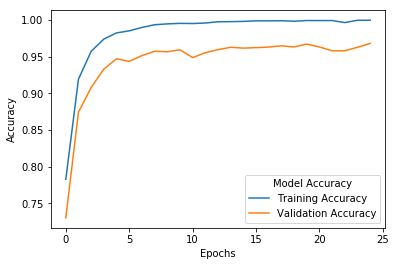

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    training_accuracies = []
    validation_accuracies = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout_rate: np.asarray([0.75], dtype=np.float32)})
            
        training_accuracy = evaluate(X_train, y_train, np.asarray([1.0], dtype=np.float32))
        training_accuracies.append(training_accuracy)
        validation_accuracy = evaluate(X_valid, y_valid, np.asarray([1.0], dtype=np.float32))
        validation_accuracies.append(validation_accuracy)

        if (i % 5 == 0):
            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy = {:.3f}".format(training_accuracy))
            print()

            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
    saver.save(sess, './lenet3')
    print("Model saved")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(EPOCHS),training_accuracies, label="Training Accuracy")
    ax.plot(range(EPOCHS),validation_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best', title='Model Accuracy')
    plt.show()

In [30]:
### Calculate the accuracy for test images. 

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('lenet3.meta')  
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    validation_accuracy = evaluate(X_test, y_test, np.asarray([1.0], dtype=np.float32))
    print("Test Accuracy = {:.1f}%".format(validation_accuracy * 100))

Test Accuracy = 94.2%


---

## Step 3: Test a Model on New Images

Downloaded five pictures of German traffic signs from the web and used my model to predict the traffic sign type.

`signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

(5, 32, 32, 1)


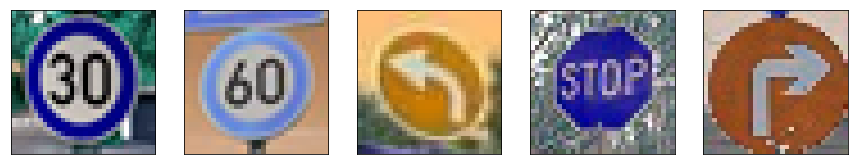

In [14]:
import glob
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
sign_indices = np.asarray([1,3,34,14,33], dtype=object)
new_images_path = np.array(glob.glob('./traffic_signs/*'))
new_images = [cv2.imread(path) for path in new_images_path]
plt.figure(figsize=(15,5))
for i, image in enumerate(new_images):
    plt.subplot(1,len(new_images_path),i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

#new_images = np.asarray(new_images, dtype=np.float32)
normalized_images = []
for image in new_images:
    normalized_images.append(normalize_grayscale(grayscale(image)).reshape((32,32,1)))
normalized_images = np.asarray(normalized_images, dtype=np.float32)
print(normalized_images.shape)

### Predict the Sign Type for Each Image

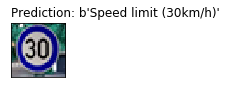

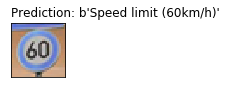

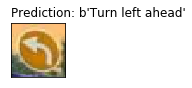

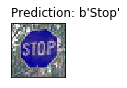

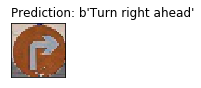

In [17]:
### Run predictions here and use the model to output the prediction for each image.
sign_names = np.recfromcsv('signnames.csv', delimiter=',')

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('lenet3.meta')  
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    # access tensors by name
    x = tf.get_default_graph().get_tensor_by_name("x_name:0")
    logits = tf.get_default_graph().get_tensor_by_name("logits_name:0")
    dropout_rate = tf.get_default_graph().get_tensor_by_name("dropout_rate_name:0")
    for i, image in enumerate(new_images):
        predictions = tf.nn.softmax(logits)
        probability = sess.run(tf.nn.top_k(predictions, k=1), feed_dict = {x: normalized_images[i:i+1], dropout_rate: np.asarray([1.0], dtype=np.float32)})
        plt.figure(figsize=(15,1))
        ax = plt.subplot(1,1,1)
        ax.set_title('Prediction: %s' % sign_names[probability.indices[0][0]][1], loc='left')
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

### Analyze Performance

In [27]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('lenet3.meta')  
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    validation_accuracy = evaluate(normalized_images, sign_indices, np.asarray([1.0], dtype=np.float32))
    print("Prediction Accuracy = {:.1f}%".format(validation_accuracy * 100))

Prediction Accuracy = 100.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [19]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('lenet3.meta')  
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    # access tensors by name
    x = tf.get_default_graph().get_tensor_by_name("x_name:0")
    dropout_rate = tf.get_default_graph().get_tensor_by_name("dropout_rate_name:0")
    logits = tf.get_default_graph().get_tensor_by_name("logits_name:0")
    for i, image in enumerate(new_images):
        predictions = tf.nn.softmax(logits)
        probability = sess.run(tf.nn.top_k(predictions, k=5), feed_dict = {x: normalized_images[i:i+1], dropout_rate:np.asarray([1.0], dtype=np.float32)})
        print("Actual Sign name: ", sign_names[sign_indices[i]][1])
        print()
        print("Top 5 predictions: ")
        for sign_index, prediction_probability in zip(probability.indices[0], probability.values[0]):
            print(sign_names[sign_index][1], ": {:.2f}%".format(prediction_probability * 100))
        print("------------------------------------------------------")
        print()

Actual Sign name:  b'Speed limit (30km/h)'

Top 5 predictions: 
b'Speed limit (30km/h)' : 80.81%
b'Speed limit (50km/h)' : 19.19%
b'Speed limit (80km/h)' : 0.00%
b'Wild animals crossing' : 0.00%
b'Speed limit (60km/h)' : 0.00%
------------------------------------------------------

Actual Sign name:  b'Speed limit (60km/h)'

Top 5 predictions: 
b'Speed limit (60km/h)' : 100.00%
b'Speed limit (80km/h)' : 0.00%
b'Speed limit (30km/h)' : 0.00%
b'End of speed limit (80km/h)' : 0.00%
b'Speed limit (50km/h)' : 0.00%
------------------------------------------------------

Actual Sign name:  b'Turn left ahead'

Top 5 predictions: 
b'Turn left ahead' : 100.00%
b'Keep right' : 0.00%
b'Speed limit (60km/h)' : 0.00%
b'Children crossing' : 0.00%
b'End of all speed and passing limits' : 0.00%
------------------------------------------------------

Actual Sign name:  b'Stop'

Top 5 predictions: 
b'Stop' : 100.00%
b'Yield' : 0.00%
b'Keep right' : 0.00%
b'Speed limit (50km/h)' : 0.00%
b'Speed limit (80

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [16]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")